<h1>0. Prepare the Environment</h1>

In [1]:
# install required packages
# !conda install -c conda-forge folium=0.5.0 --yes
# !conda install -c conda-forge geopy --yes
print('Installation process is complete')

Installation process is complete


In [2]:
# import required libraries
import json
import itertools
import pandas as pd
from geopy.geocoders import Nominatim
import requests
import folium
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import collections
from sklearn.cluster import KMeans
print('Library import is done')

Library import is done


<h1>1. Acquire the Data</h1>

<h2>Moscow Regions and Population</h2>

<h3>Polygons From the GeoJSON file</h3>
<p><em>Source: <a href="http://gis-lab.info/qa/moscow-atd.html">GIS-Lab</a></em></p>

In [3]:
# read the geojson file
with open('mo.geojson') as datasource:
    geojson_data = json.load(datasource)
print('Source file reading is done')

Source file reading is done


In [4]:
# get districts and coordinates
coordinates = {}
for feature in geojson_data['features']:
    name = feature['properties']['NAME']
    points = feature['geometry']['coordinates']
    coordinates[name] = points
print('Coordinates setting is done')

Coordinates setting is done


In [5]:
# see if we have any multipolygons in our geojson
print('These districts have multipolygons:')
print()
for key, value in coordinates.items():
    if len(value) > 1:
        print(key, '--', len(value))

These districts have multipolygons:

Kiyevsky -- 2
Vnukovo -- 2
Vnukovskoye -- 2
Vostochny -- 4
Kuntsevo -- 5


In [6]:
# make coordinates more readable and more comfortable to work with

# function for multipolygons
def flatten_many(lst):
    many = []
    for item in lst:
        if isinstance(item, list):
            for i in item:
                if isinstance(i, list):
                    many.append(i)
    return (list(itertools.chain(*many)))

# function for simple polygons
def flatten_one(lst):
    one = []
    for item in lst:
        if isinstance(item, list):
            one.append(item)
    return(list(itertools.chain(*one)))

# get all coordinates right
for key, value in coordinates.items():
    if len(value) > 1:
        coordinates[key] = flatten_many(coordinates[key])
    else:
        coordinates[key] = flatten_one(coordinates[key])
print('Coordinates got right')

Coordinates got right


In [7]:
# check if everything looks good

# check the polygon
print('Polygon example:')
print(coordinates['Novokosino'])

# check the multipolygon
# print('Multipolygon example:')
# print(coordinates['Kuntsevo'])

Polygon example:
[[37.84042, 55.73049], [37.84063, 55.73196], [37.84165, 55.74049], [37.84181, 55.74303], [37.84201, 55.74722], [37.84254, 55.74718], [37.84265, 55.74673], [37.84315, 55.74633], [37.84368, 55.7459], [37.8448, 55.74531], [37.84571, 55.74487], [37.8468, 55.74459], [37.84792, 55.74454], [37.848, 55.7445], [37.84971, 55.74462], [37.85142, 55.74476], [37.85297, 55.74488], [37.85392, 55.74495], [37.85662, 55.74507], [37.85919, 55.74515], [37.86054, 55.74524], [37.86323, 55.74557], [37.86422, 55.74572], [37.86474, 55.74585], [37.87285, 55.74741], [37.87952, 55.74873], [37.88254, 55.74934], [37.88735, 55.74846], [37.88771, 55.74858], [37.88825, 55.74846], [37.88871, 55.74714], [37.88933, 55.74547], [37.89003, 55.74363], [37.89095, 55.74219], [37.8904, 55.74208], [37.89008, 55.74187], [37.89009, 55.7416], [37.88583, 55.74261], [37.8836, 55.74269], [37.88175, 55.74273], [37.88075, 55.7425], [37.88011, 55.74225], [37.88003, 55.74175], [37.87801, 55.73787], [37.87316, 55.73816], [3

In [8]:
# find the center of each borough in case the geolocator won't be able to find any
avg_lat = {}
avg_long = {}

for key, value in coordinates.items():
    xc = []
    yc = []
    for item in value:
        xc.append(item[1])
        yc.append(item[0])
    xca = sum(xc) / len(xc)
    yca = sum(yc) / len(yc)
    avg_lat[key] = xca
    avg_long[key] = yca
print('Centers of each borough are found.')

Centers of each borough are found.


<h3>Population Data</h3>
<p><em>Population data was manually collected from open data sources, including <a href="http://wikipedia.org">Wikipedia</a> and put together in a csv file</em></p>

In [9]:
# open the file and make it a dataframe
moscow_data = pd.read_csv('moscow.csv')
moscow_data.head()

,District,Borough,Population
0,Central Administrative Okrug,Arbat,25699
1,Central Administrative Okrug,Basmanny,100899
2,Central Administrative Okrug,Khamovniki,97110
3,Central Administrative Okrug,Krasnoselsky,45229
4,Central Administrative Okrug,Meshchansky,56077


<h3>Put the Data Together</h3>

In [10]:
# add the geolocation data to that dataframe
moscow_data['AvgLatitude'] = moscow_data['Borough'].map(avg_lat)
moscow_data['AvgLongitude'] = moscow_data['Borough'].map(avg_long)
print('Geolocation data is added to the dataframe.')

# drop the missing data
moscow_data = moscow_data.dropna()
print('Missing data is dropped.')

# look at the data
moscow_data.head()

Geolocation data is added to the dataframe.
Missing data is dropped.


,District,Borough,Population,AvgLatitude,AvgLongitude
0,Central Administrative Okrug,Arbat,25699,55.751192,37.595551
1,Central Administrative Okrug,Basmanny,100899,55.765157,37.666924
2,Central Administrative Okrug,Khamovniki,97110,55.740181,37.588317
3,Central Administrative Okrug,Krasnoselsky,45229,55.773022,37.647721
4,Central Administrative Okrug,Meshchansky,56077,55.776221,37.627220


<h3>Acquire Precise Data from GeoLocator</h3>

In [11]:
# stitch together districts and boroughs and put them in a list for more precise search
disborough = moscow_data.filter(['District', 'Borough'], axis=1)
db = []
for row in disborough.itertuples():
    r = ', '.join([row.District, row.Borough])
    db.append(r)
print('Done.')

# print the list to make sure it looks good
# print(db)

Done.


In [12]:
# get the actual data from geolocator
latitudes = []
longitudes = []
dists = {}
headers = ['FullPlaceName', 'RealLatitude', 'RealLongitude']
for item in db:
    geolocator = Nominatim(user_agent='СCoursera')
    location = geolocator.geocode(item)
    if location is None:
        latitudes.append(None)
        longitudes.append(None)
    else:
        latitude = location.latitude
        longitude = location.longitude
        latitudes.append(latitude)
        longitudes.append(longitude)
print('Actual data acquired')

Actual data acquired


In [13]:
# combine it in the dictionary
dists.update({headers[0]:db})
dists.update({headers[1]:latitudes})
dists.update({headers[2]:longitudes})

# create the dataframe from the acquired data
dists_df = pd.DataFrame.from_dict(dists)
dists_df.head()

,FullPlaceName,RealLatitude,RealLongitude
0,"Central Administrative Okrug, Arbat",55.751199,37.589872
1,"Central Administrative Okrug, Basmanny",55.767281,37.669773
2,"Central Administrative Okrug, Khamovniki",55.740047,37.573958
3,"Central Administrative Okrug, Krasnoselsky",55.777447,37.654160
4,"Central Administrative Okrug, Meshchansky",55.779169,37.627755


In [14]:
# reset indexes to match the geometry
moscow_data = moscow_data.reset_index()

In [15]:
# combine all the data together
moscow_data['FullPlaceName'] = dists_df['FullPlaceName']
moscow_data['Latitude'] = dists_df['RealLatitude']
moscow_data['Longitude'] = dists_df['RealLongitude']

# if no data exists, replace it with data from the geojson
moscow_data.Latitude.fillna(moscow_data.AvgLatitude, inplace=True)
moscow_data.Longitude.fillna(moscow_data.AvgLongitude, inplace=True)

# rearrange columns for better readability
moscow_data = moscow_data[['District', 'Borough', 'FullPlaceName', 'Latitude', 'Longitude', 'Population']]

# see the result
moscow_data.head()

,District,Borough,FullPlaceName,Latitude,Longitude,Population
0,Central Administrative Okrug,Arbat,"Central Administrative Okrug, Arbat",55.751199,37.589872,25699
1,Central Administrative Okrug,Basmanny,"Central Administrative Okrug, Basmanny",55.767281,37.669773,100899
2,Central Administrative Okrug,Khamovniki,"Central Administrative Okrug, Khamovniki",55.740047,37.573958,97110
3,Central Administrative Okrug,Krasnoselsky,"Central Administrative Okrug, Krasnoselsky",55.777447,37.654160,45229
4,Central Administrative Okrug,Meshchansky,"Central Administrative Okrug, Meshchansky",55.779169,37.627755,56077


<h2>Moscow Venues Data from Forsquare</h2>

<h3>Foursquare Credentials</h3>

In [16]:
# @hidden_cell
file = open('fsq_id', 'w+')
file.write('Z11G3S5N1GP22MHEHSIZYMUMOXQ50BGTEOY5PHTRAAUDXXHY')
file.close()

file = open('fsq_s', 'w+')
file.write('EQOOPXLNB1CPDSN1LPSBAXOOQ3TVZIPCSLZGREE03L1CQUXY')
file.close()

In [17]:
# foursquare settings
CLIENT_ID = open('fsq_id', 'r').read()
CLIENT_SECRET = open('fsq_s', 'r').read()
VERSION = '20190101'
LIMIT = 500
radius = 1000

<h3>Acquire the Data</h3>

In [18]:
# Get top venues in Moscow

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)

        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        'FullPlaceName',
        'Latitude',
        'Longitude',
        'Venue',
        'VenueLatitude',
        'VenueLongitude',
        'Category']

    return (nearby_venues)

print('Function defined')

Function defined


In [19]:
# Get those venues into a dataframe
moscow_venues = getNearbyVenues(names=moscow_data['FullPlaceName'],
                                   latitudes=moscow_data['Latitude'],
                                   longitudes=moscow_data['Longitude']
                                  )
print('Shape of the moscow_venues dataframe:', moscow_venues.shape)
moscow_venues.head()

Shape of the moscow_venues dataframe: (2572, 7)


,FullPlaceName,Latitude,Longitude,Venue,VenueLatitude,VenueLongitude,Category
0,"Central Administrative Okrug, Arbat",55.751199,37.589872,Corner Café & Kitchen,55.751496,37.586757,Japanese Restaurant
1,"Central Administrative Okrug, Arbat",55.751199,37.589872,Театр им. Вахтангова,55.749569,37.591638,Theater
2,"Central Administrative Okrug, Arbat",55.751199,37.589872,Obedbufet (Обедбуфет),55.752268,37.592275,Buffet
3,"Central Administrative Okrug, Arbat",55.751199,37.589872,Buffalo's,55.751840,37.587376,Wings Joint
4,"Central Administrative Okrug, Arbat",55.751199,37.589872,Кофемания,55.752094,37.588102,Coffee Shop


In [20]:
moscow_venues.to_csv('moscow_venues.csv')

<h3>Define venues categories</h3>
<p><em>As the goal of this study is to learn about restaurants, bars and fastfood venues, I'm going to restrict the list to these types of venues</em></p>

In [21]:
# get the list of all categories
categories = list(moscow_venues['Category'].drop_duplicates())
print('Categories are in the list.')

# see if categories look good
# print(categories)

Categories are in the list.


In [22]:
# manually select the categories from the list above

# restaurants
restaurants = [
    'American Restaurant',
    'Argentinian Restaurant',
    'Asian Restaurant',
    'Belgian Restaurant',
    'Caucasian Restaurant',
    'Chinese Restaurant',
    'Comfort Food Restaurant',
    'Czech Restaurant',
    'Eastern European Restaurant',
    'English Restaurant',
    'French Restaurant',
    'Gastropub',
    'German Restaurant',
    'Gourmet Shop',
    'Greek Restaurant',
    'Halal Restaurant',
    'Hawaiian Restaurant',
    'Indian Restaurant',
    'Israeli Restaurant',
    'Italian Restaurant',
    'Japanese Restaurant',
    'Jewish Restaurant',
    'Korean Restaurant',
    'Mediterranean Restaurant',
    'Mexican Restaurant',
    'Middle Eastern Restaurant',
    'Modern European Restaurant',
    'Moroccan Restaurant',
    'Peruvian Restaurant',
    'Restaurant',
    'Russian Restaurant',
    'Scandinavian Restaurant',
    'Seafood Restaurant',
    'Spanish Restaurant',
    'Sushi Restaurant',
    'Thai Restaurant',
    'Theme Restaurant',
    'Turkish Restaurant',
    'Ukrainian Restaurant',
    'Vegetarian / Vegan Restaurant',
    'Vietnamese Restaurant',
    'Steakhouse']

#fastfood and cafe
fastfood = [
    'BBQ Joint',
    'Bistro',
    'Blini House',
    'Creperie',
    'Donut Shop',
    'Burger Joint',
    'Breakfast Spot',
    'Dumpling Restaurant',
    'Falafel Restaurant',
    'Fast Food Restaurant',
    'Food Court',
    'Fried Chicken Joint',
    'Hot Dog Joint',
    'Kebab Restaurant',
    'Noodle House',
    'Pelmeni House',
    'Pizza Place',
    'Shawarma Place',
    'Udon Restaurant',
    'Wings Joint',
    'Fish & Chips Shop',
    'Pastry Shop',
    'Pie Shop',
    'Salad Place',
    'Sandwich Place',
    'Snack Place',
    'Soup Place',
    'Buffet',
    'Diner',
    'Bakery',
    'Bagel Shop',
    'Café',
    'Cafeteria',
    'Coffee Shop',
    'Cupcake Shop',
    'Dessert Shop',
    'Frozen Yogurt Shop',
    'Ice Cream Shop']

# bars, pubs, etc.
bars = [
    'Bar',
    'Beer Bar',
    'Beer Garden',
    'Brewery',
    'Cocktail Bar',
    'Dive Bar',
    'Hotel Bar',
    'Irish Pub',
    'Karaoke Bar',
    'Lounge',
    'Pub',
    'Sports Bar',
    'Whisky Bar',
    'Wine Bar',
    'Wine Shop']

<h1>2. Prepare the Acquired Data for Analysis</h1>

<h2>Prepare the Venues Data</h2>

<h3>Venues Selection</h3>

In [23]:
# create separate dataframes for each category
moscow_restaurants = moscow_venues.loc[moscow_venues['Category'].isin(restaurants)]
moscow_fastfood = moscow_venues.loc[moscow_venues['Category'].isin(fastfood)]
moscow_bars = moscow_venues.loc[moscow_venues['Category'].isin(bars)]

In [24]:
# see how many venues we have in each category
print('There are', moscow_restaurants.shape[0], 'restaurants,', moscow_fastfood.shape[0], 'fastfood venues and', moscow_bars.shape[0], 'bars in Moscow.')

There are 319 restaurants, 441 fastfood venues and 97 bars in Moscow.


In [25]:
# add a common category mark for each venue
moscow_bars.insert(6,'CommonCategory','bar')
moscow_fastfood.insert(6,'CommonCategory','fastfood')
moscow_restaurants.insert(6,'CommonCategory','restaurant')

In [26]:
moscow_data.head()

,District,Borough,FullPlaceName,Latitude,Longitude,Population
0,Central Administrative Okrug,Arbat,"Central Administrative Okrug, Arbat",55.751199,37.589872,25699
1,Central Administrative Okrug,Basmanny,"Central Administrative Okrug, Basmanny",55.767281,37.669773,100899
2,Central Administrative Okrug,Khamovniki,"Central Administrative Okrug, Khamovniki",55.740047,37.573958,97110
3,Central Administrative Okrug,Krasnoselsky,"Central Administrative Okrug, Krasnoselsky",55.777447,37.654160,45229
4,Central Administrative Okrug,Meshchansky,"Central Administrative Okrug, Meshchansky",55.779169,37.627755,56077


In [27]:
moscow_bars.head()

,FullPlaceName,Latitude,Longitude,Venue,VenueLatitude,VenueLongitude,CommonCategory,Category
24,"Central Administrative Okrug, Arbat",55.751199,37.589872,Каудаль,55.751801,37.583301,bar,Wine Shop
38,"Central Administrative Okrug, Arbat",55.751199,37.589872,Royal Arbat,55.751850,37.584043,bar,Karaoke Bar
44,"Central Administrative Okrug, Arbat",55.751199,37.589872,Kalina Bar,55.751210,37.583984,bar,Cocktail Bar
63,"Central Administrative Okrug, Arbat",55.751199,37.589872,Проточный,55.750301,37.582501,bar,Pub
73,"Central Administrative Okrug, Arbat",55.751199,37.589872,The Lounge Bar,55.750085,37.583108,bar,Hotel Bar


In [28]:
# combine all of them together
food_venues = [moscow_restaurants, moscow_fastfood, moscow_bars]
food_data = pd.concat(food_venues)
food_data.head()

,FullPlaceName,Latitude,Longitude,Venue,VenueLatitude,VenueLongitude,CommonCategory,Category
0,"Central Administrative Okrug, Arbat",55.751199,37.589872,Corner Café & Kitchen,55.751496,37.586757,restaurant,Japanese Restaurant
8,"Central Administrative Okrug, Arbat",55.751199,37.589872,Граци Рагацци,55.752137,37.591267,restaurant,Italian Restaurant
11,"Central Administrative Okrug, Arbat",55.751199,37.589872,Бараshка,55.752055,37.586117,restaurant,Middle Eastern Restaurant
12,"Central Administrative Okrug, Arbat",55.751199,37.589872,Taksim,55.752240,37.591971,restaurant,Turkish Restaurant
33,"Central Administrative Okrug, Arbat",55.751199,37.589872,Чайхона № 1,55.752383,37.585924,restaurant,Middle Eastern Restaurant


In [29]:
moscow_data.head()

,District,Borough,FullPlaceName,Latitude,Longitude,Population
0,Central Administrative Okrug,Arbat,"Central Administrative Okrug, Arbat",55.751199,37.589872,25699
1,Central Administrative Okrug,Basmanny,"Central Administrative Okrug, Basmanny",55.767281,37.669773,100899
2,Central Administrative Okrug,Khamovniki,"Central Administrative Okrug, Khamovniki",55.740047,37.573958,97110
3,Central Administrative Okrug,Krasnoselsky,"Central Administrative Okrug, Krasnoselsky",55.777447,37.654160,45229
4,Central Administrative Okrug,Meshchansky,"Central Administrative Okrug, Meshchansky",55.779169,37.627755,56077


In [30]:
# create a whole new dataframe, containing all the information about our venues
food_data = pd.merge(moscow_data, food_data, how='right', on='FullPlaceName')

# make it look good
food_data = food_data.rename(columns={'Latitude_x': 'Latitude', 'Longitude_x': 'Longitude'})
food_data = food_data[['FullPlaceName', 'District', 'Borough', 'Latitude', 'Longitude', 'Population', 'Venue', 'VenueLatitude', 'VenueLongitude', 'CommonCategory', 'Category']].dropna()
print(food_data.shape)
food_data.head(20)

(857, 11)


,FullPlaceName,District,Borough,Latitude,Longitude,Population,Venue,VenueLatitude,VenueLongitude,CommonCategory,Category
0,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Corner Café & Kitchen,55.751496,37.586757,restaurant,Japanese Restaurant
1,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Граци Рагацци,55.752137,37.591267,restaurant,Italian Restaurant
2,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Бараshка,55.752055,37.586117,restaurant,Middle Eastern Restaurant
3,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Taksim,55.752240,37.591971,restaurant,Turkish Restaurant
4,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Чайхона № 1,55.752383,37.585924,restaurant,Middle Eastern Restaurant
5,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Хинкальная,55.748943,37.588480,restaurant,Caucasian Restaurant
6,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Hard Rock Cafe,55.748122,37.586462,restaurant,American Restaurant
7,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Босфор / Bosfor,55.747967,37.587879,restaurant,Turkish Restaurant
8,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Лодка,55.751183,37.583491,restaurant,Asian Restaurant
9,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Ресторан Дома Актера,55.749118,37.592156,restaurant,Restaurant


In [31]:
food_data.to_csv('food_data.csv')

<h1>3. Visualize the Data</h1>

<h2>Population</h2>

<h3>Population by District</h3>

District
Southern Administrative Okrug         1593095
Eastern Administrative Okrug          1394497
North-Eastern Administrative Okrug    1240062
South-Western Administrative Okrug    1179211
South-Eastern Administrative Okrug    1116924
Northern Administrative Okrug         1112847
Western Administrative Okrug          1049104
North-Western Administrative Okrug     779965
Central Administrative Okrug           701353
Novomoskovsky Administrative Okrug     232982
Zelenogradsky Administrative Okrug     174805
Troitsky Administrative Okrug          123941
Name: Population, dtype: int64


Text(0, 0.5, 'District')

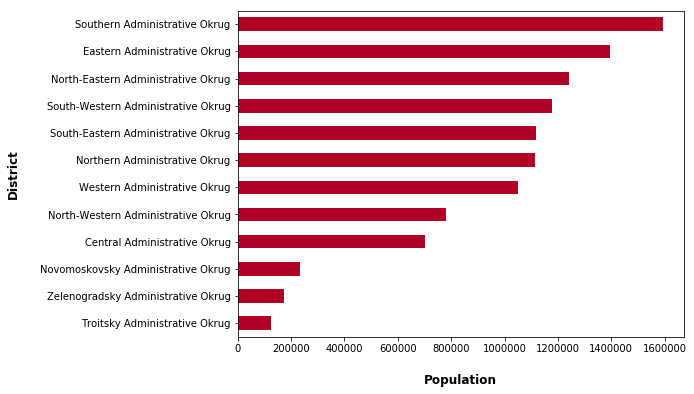

In [32]:
# see population by district

# count sum of people living in each borough of a district
population_dist = moscow_data.groupby(['District'])['Population'].sum(level="Population")
print(population_dist.sort_values(ascending=False))

# plot the data
ax = population_dist.sort_values(ascending=True).plot(kind='barh',color='#B10026',figsize=(8,6))
ax.set_xlabel("Population", labelpad=20, weight='bold', size=12)
ax.set_ylabel("District", labelpad=20, weight='bold', size=12)

<h3>Choropleth Map of Population by Borough</h3>

In [33]:
# create a map base
address = 'Moscow, Russia'
geolocator = Nominatim(user_agent='IBM')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Coordinates of {} are {}, {}.'.format(address, latitude, longitude))
map_moscow_population = folium.Map(location=[latitude, longitude], zoom_start=9)

Coordinates of Moscow, Russia are 55.7504461, 37.6174943.


In [34]:
# put population data on the map
geo = r'mo.geojson'

map_moscow_population.choropleth(
    geo_data=geo,
    data=moscow_data,
    columns=['Borough', 'Population'],
    key_on='feature.properties.NAME',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    line_opacity=0.3,
    legend_name='Moscow Population by Borough'
)

In [35]:
# show the map
map_moscow_population

<h2>Categories of Venues</h2>

In [36]:
# another look at food_data dataframe
food_data.head()

,FullPlaceName,District,Borough,Latitude,Longitude,Population,Venue,VenueLatitude,VenueLongitude,CommonCategory,Category
0,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Corner Café & Kitchen,55.751496,37.586757,restaurant,Japanese Restaurant
1,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Граци Рагацци,55.752137,37.591267,restaurant,Italian Restaurant
2,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Бараshка,55.752055,37.586117,restaurant,Middle Eastern Restaurant
3,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Taksim,55.752240,37.591971,restaurant,Turkish Restaurant
4,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Чайхона № 1,55.752383,37.585924,restaurant,Middle Eastern Restaurant


In [37]:
# see how popular are categories among common categories
food_data.groupby(['CommonCategory'])['Category'].value_counts()

CommonCategory  Category                     
bar             Wine Shop                         20
                Bar                               19
                Beer Bar                          11
                Wine Bar                           9
                Cocktail Bar                       7
                Hotel Bar                          6
                Pub                                6
                Irish Pub                          5
                Karaoke Bar                        5
                Sports Bar                         5
                Brewery                            2
                Lounge                             2
fastfood        Coffee Shop                      100
                Café                              80
                Bakery                            49
                Fast Food Restaurant              44
                Pizza Place                       44
                Burger Joint                      17


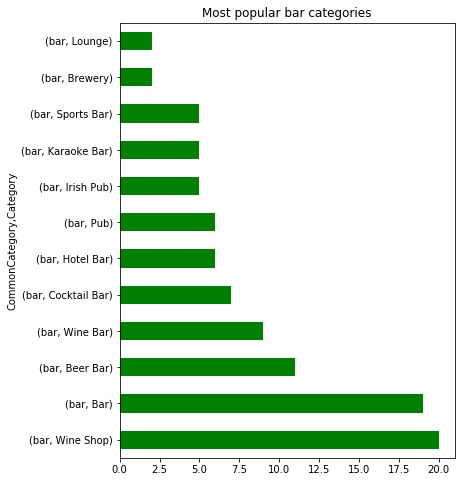

In [38]:
# see most popular bar categories
food_data[food_data.CommonCategory == 'bar'].groupby(['CommonCategory'])['Category'].value_counts(normalize=False).plot(kind='barh', figsize=(6,8), color='green', title='Most popular bar categories')


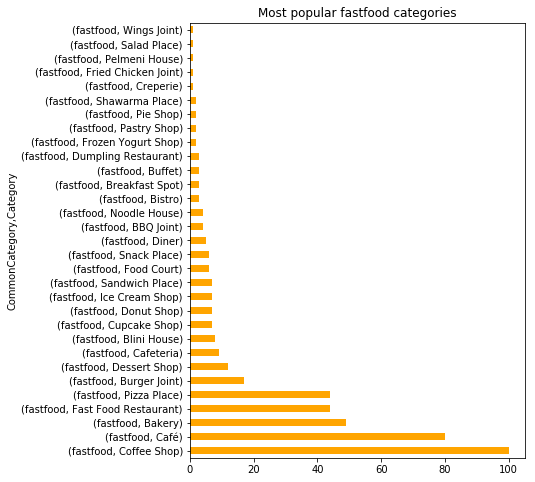

In [39]:
# see most popular fastfood categories
food_data[food_data.CommonCategory == 'fastfood'].groupby(['CommonCategory'])['Category'].value_counts(normalize=False).plot(kind='barh', figsize=(6,8), color='orange', title='Most popular fastfood categories')

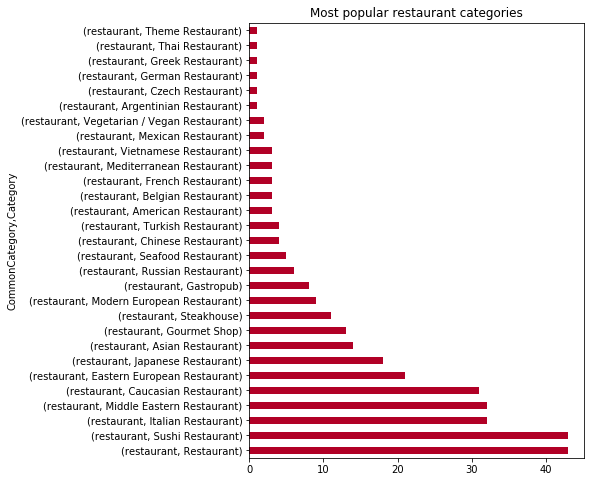

In [40]:
# see most popular restaurant categories
food_data[food_data.CommonCategory == 'restaurant'].groupby(['CommonCategory'])['Category'].value_counts(normalize=False).plot(kind='barh', figsize=(6,8), color='#B10026', title='Most popular restaurant categories')

<h3>Venue Categories in Each District</h3>

In [41]:
# how many of each category in every common category
food_data.groupby(['District'])['CommonCategory'].value_counts()

District                            CommonCategory
Central Administrative Okrug        fastfood          115
                                    restaurant        110
                                    bar                41
Eastern Administrative Okrug        fastfood           39
                                    restaurant         32
                                    bar                 9
North-Eastern Administrative Okrug  fastfood           49
                                    restaurant         32
                                    bar                 4
North-Western Administrative Okrug  fastfood           20
                                    restaurant         14
                                    bar                 5
Northern Administrative Okrug       fastfood           53
                                    restaurant         32
                                    bar                 7
Novomoskovsky Administrative Okrug  fastfood            4
                     

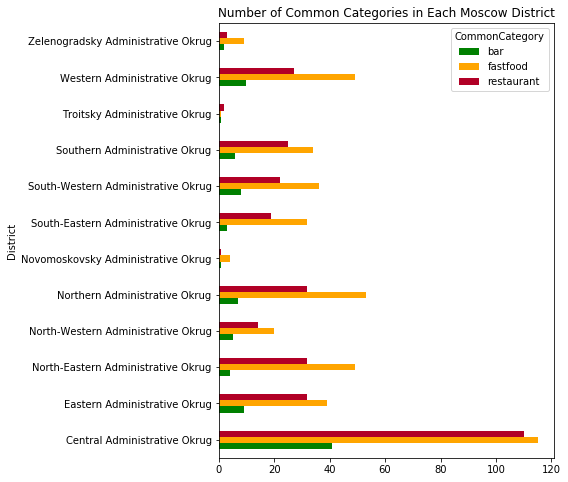

In [42]:
# plot how often each category appears in every district
cc_freq = pd.crosstab([food_data.District],food_data['CommonCategory'])
cc_freq.plot(kind='barh', figsize=(6,8), color = ['green', 'orange', '#B10026'], title='Number of Common Categories in Each Moscow District')

<h3>Common Categories of Venues</h3>

In [43]:
# count how many of each category we have
food_data['CommonCategory'].value_counts()

fastfood      441
restaurant    319
bar            97
Name: CommonCategory, dtype: int64

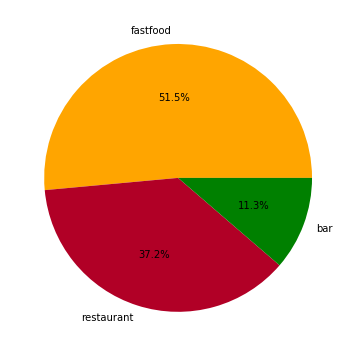

In [46]:
# see it on the pie chart

ven_cnt = dict(food_data['CommonCategory'].value_counts())
clrs = ['orange', '#B10026', 'green']
vlbls = ven_cnt.keys()
vvls = ven_cnt.values()
plt.figure(figsize=(6,8))
plt.pie(vvls, colors=clrs, labels=vlbls, autopct='%1.1f%%')
plt.show()

<h3>Bars in Each District</h3>

In [47]:
# how many bars in each district
food_data[food_data.CommonCategory == 'bar'].groupby(['District'])['CommonCategory'].value_counts(normalize=False)

District                            CommonCategory
Central Administrative Okrug        bar               41
Eastern Administrative Okrug        bar                9
North-Eastern Administrative Okrug  bar                4
North-Western Administrative Okrug  bar                5
Northern Administrative Okrug       bar                7
Novomoskovsky Administrative Okrug  bar                1
South-Eastern Administrative Okrug  bar                3
South-Western Administrative Okrug  bar                8
Southern Administrative Okrug       bar                6
Troitsky Administrative Okrug       bar                1
Western Administrative Okrug        bar               10
Zelenogradsky Administrative Okrug  bar                2
Name: CommonCategory, dtype: int64

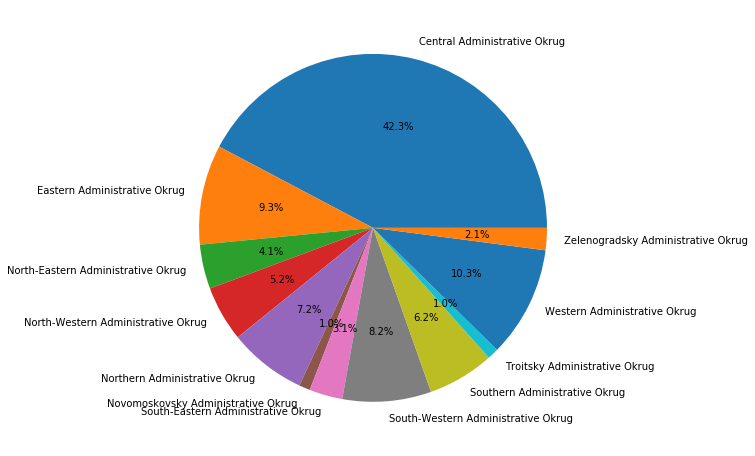

In [48]:
# plot bars
bar_cnt = collections.OrderedDict(food_data[food_data.CommonCategory == 'bar'].groupby(['District'])['CommonCategory'].value_counts(normalize=False))
blbls = [i[0] for i in bar_cnt.keys()]
bvls = bar_cnt.values()
f = [i[0] for i in bar_cnt.keys()]
plt.figure(figsize=(8,8))
plt.pie(bvls,  labels=blbls, autopct='%1.1f%%')
plt.show()

<h3>Restaurants in Each District</h3>

In [49]:
# how many restaurants in each district
food_data[food_data.CommonCategory == 'restaurant'].groupby(['District'])['CommonCategory'].value_counts(normalize=False)

District                            CommonCategory
Central Administrative Okrug        restaurant        110
Eastern Administrative Okrug        restaurant         32
North-Eastern Administrative Okrug  restaurant         32
North-Western Administrative Okrug  restaurant         14
Northern Administrative Okrug       restaurant         32
Novomoskovsky Administrative Okrug  restaurant          1
South-Eastern Administrative Okrug  restaurant         19
South-Western Administrative Okrug  restaurant         22
Southern Administrative Okrug       restaurant         25
Troitsky Administrative Okrug       restaurant          2
Western Administrative Okrug        restaurant         27
Zelenogradsky Administrative Okrug  restaurant          3
Name: CommonCategory, dtype: int64

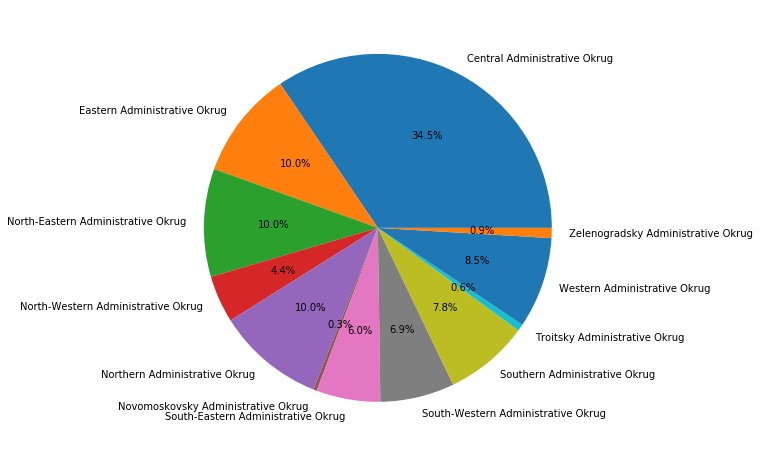

In [50]:
# plot restaurants
rest_cnt = collections.OrderedDict(food_data[food_data.CommonCategory == 'restaurant'].groupby(['District'])['CommonCategory'].value_counts(normalize=False))
rlbls = [i[0] for i in rest_cnt.keys()]
rvls = rest_cnt.values()
f = [i[0] for i in rest_cnt.keys()]
plt.figure(figsize=(8,8))
plt.pie(rvls,  labels=rlbls, autopct='%1.1f%%')
plt.show()

<h3>Fastfood Venues in Each District</h3>
<p><em>Includes coffee shops, cafees, diners and other places where people can grab a bite and go on with their business</em></p>

In [51]:
# number of fastfood venues in each district
food_data[food_data.CommonCategory == 'fastfood'].groupby(['District'])['CommonCategory'].value_counts(normalize=False)

District                            CommonCategory
Central Administrative Okrug        fastfood          115
Eastern Administrative Okrug        fastfood           39
North-Eastern Administrative Okrug  fastfood           49
North-Western Administrative Okrug  fastfood           20
Northern Administrative Okrug       fastfood           53
Novomoskovsky Administrative Okrug  fastfood            4
South-Eastern Administrative Okrug  fastfood           32
South-Western Administrative Okrug  fastfood           36
Southern Administrative Okrug       fastfood           34
Troitsky Administrative Okrug       fastfood            1
Western Administrative Okrug        fastfood           49
Zelenogradsky Administrative Okrug  fastfood            9
Name: CommonCategory, dtype: int64

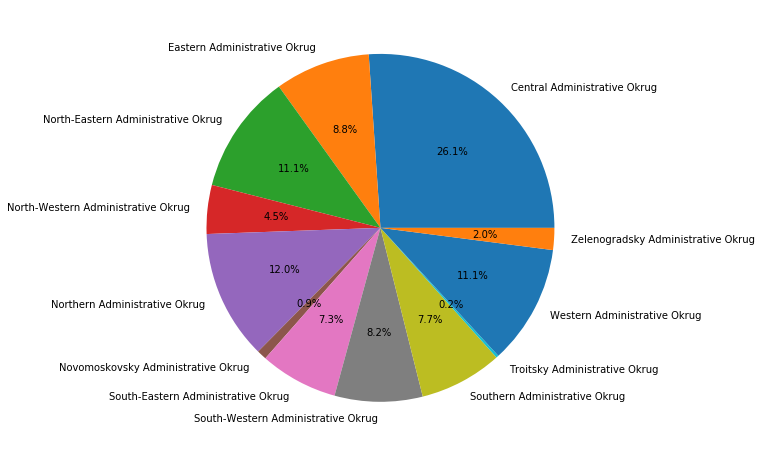

In [52]:
ff_cnt = collections.OrderedDict(food_data[food_data.CommonCategory == 'fastfood'].groupby(['District'])['CommonCategory'].value_counts(normalize=False))
fflbls = [i[0] for i in ff_cnt.keys()]
ffvls = ff_cnt.values()
f = [i[0] for i in ff_cnt.keys()]
plt.figure(figsize=(8,8))
plt.pie(ffvls,  labels=fflbls, autopct='%1.1f%%')
plt.show()

<h3>See Venue Categories on the Map</h3>

In [53]:
# see venues on the map, devided by common category (bar, restaurant, fastfood)
venues_map = folium.Map(location=[latitude, longitude], zoom_start=10)
for label, cat, lat, long in zip(food_data['Venue'], food_data['CommonCategory'], food_data['VenueLatitude'], food_data['VenueLongitude']):
    if cat == 'bar':
        clr = 'green'
    elif cat == 'restaurant':
        clr = '#B10026'
    elif cat == 'fastfood':
        clr = 'orange'
    else:
        clr = 'blue'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, long], radius = 1, popup = label, color = clr, fill = False, fill_color = 'white', fill_opacity = 0.5, parse_html = False).add_to(venues_map)
venues_map.save('venues_map.html')


In [54]:
venues_map

In [55]:
# see if population and number of venues depend on each other

# see number of venues in each borough
num_ven = (food_data.groupby(['Borough'])['Venue'].count()).to_dict()
print(num_ven)

{'Aeroport': 9, 'Akademichesky': 13, 'Alexeyevsky': 3, 'Altufyevsky': 2, 'Arbat': 50, 'Babushkinsky': 12, 'Basmanny': 3, 'Begovoy': 13, 'Beskudnikovsky': 3, 'Bibirevo': 8, 'Bogorodskoye': 2, 'Butyrsky': 2, 'Chertanovo Severnoye': 7, 'Chertanovo Tsentralnoye': 20, 'Chertanovo Yuzhnoye': 4, 'Cheryomushki': 2, 'Danilovsky': 16, 'Desyonovskoye': 1, 'Dmitrovsky': 5, 'Donskoy': 5, 'Dorogomilovo': 12, 'Fili-Davydkovo': 14, 'Filyovsky park': 7, 'Gagarinsky': 11, 'Golovinsky': 3, 'Golyanovo': 2, 'Ivanovskoye': 4, 'Izmaylovo': 13, 'Kapotnya': 2, 'Khamovniki': 7, 'Khoroshyovo-Mnyovniki': 11, 'Khoroshyovsky': 13, 'Khovrino': 7, 'Kiyevsky': 1, 'Konkovo': 6, 'Koptevo': 2, 'Kosino-Ukhtomsky': 5, 'Kotlovka': 3, 'Krasnoselsky': 10, 'Krylatskoye': 18, 'Kryukovo': 7, 'Kurkino': 7, 'Kuzminki': 6, 'Lefortovo': 8, 'Levoberezhny': 4, 'Lomonosovsky': 11, 'Losinoostrovsky': 3, 'Lyublino': 7, 'Marfino': 3, 'Maryina roshcha': 9, 'Maryino': 1, 'Matushkino': 4, 'Meshchansky': 34, 'Metrogorodok': 1, 'Mitino': 9, 'M

In [56]:
num_pop = dict(zip(food_data.Borough, food_data.Population))
print(num_pop)

{'Arbat': 25699, 'Basmanny': 100899, 'Khamovniki': 97110, 'Krasnoselsky': 45229, 'Meshchansky': 56077, 'Presnensky': 116979, 'Tagansky': 109993, 'Tverskoy': 75955, 'Yakimanka': 22822, 'Zamoskvorechye': 50590, 'Aeroport': 74775, 'Begovoy': 44385, 'Beskudnikovsky': 74790, 'Dmitrovsky': 88931, 'Golovinsky': 102160, 'Khoroshyovsky': 55949, 'Khovrino': 79092, 'Koptevo': 97989, 'Levoberezhny': 51309, 'Molzhaninovsky': 2929, 'Savyolovsky': 57814, 'Sokol': 57317, 'Vostochnoye Degunino ': 97083, 'Voykovsky': 67470, 'Zapadnoye Degunino': 76756, 'Alexeyevsky': 73429, 'Altufyevsky': 50091, 'Babushkinsky': 77491, 'Bibirevo': 151334, 'Butyrsky': 60922, 'Losinoostrovsky': 72640, 'Marfino': 23971, 'Maryina roshcha': 60194, 'Ostankinsky': 57707, 'Otradnoye': 168972, 'Rostokino': 35134, 'Severnoye Medvedkovo': 111804, 'Severny': 9629, 'Sviblovo': 52824, 'Yaroslavsky': 84739, 'Yuzhnoye Medvedkovo': 72716, 'Bogorodskoye': 98602, 'Golyanovo': 159147, 'Ivanovskoye': 127905, 'Izmaylovo': 110099, 'Kosino-Ukht

In [57]:
keys = set(num_ven.keys() | num_pop.keys())
np.corrcoef(
    [num_ven.get(x, 0) for x in keys],
    [num_pop.get(x, 0) for x in keys])[0,1]

-0.04834971544901197

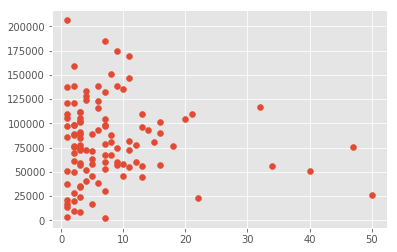

In [58]:
%matplotlib inline
mpl.style.use('ggplot')
plt.scatter([num_ven.get(x, 0) for x in keys], [num_pop.get(x, 0) for x in keys])
plt.show()

In [59]:

o_num_ven = collections.OrderedDict(sorted(num_ven.items()))
o_num_pop = collections.OrderedDict(sorted(num_pop.items()))
print(o_num_ven)
print()
print(o_num_pop)

OrderedDict([('Aeroport', 9), ('Akademichesky', 13), ('Alexeyevsky', 3), ('Altufyevsky', 2), ('Arbat', 50), ('Babushkinsky', 12), ('Basmanny', 3), ('Begovoy', 13), ('Beskudnikovsky', 3), ('Bibirevo', 8), ('Bogorodskoye', 2), ('Butyrsky', 2), ('Chertanovo Severnoye', 7), ('Chertanovo Tsentralnoye', 20), ('Chertanovo Yuzhnoye', 4), ('Cheryomushki', 2), ('Danilovsky', 16), ('Desyonovskoye', 1), ('Dmitrovsky', 5), ('Donskoy', 5), ('Dorogomilovo', 12), ('Fili-Davydkovo', 14), ('Filyovsky park', 7), ('Gagarinsky', 11), ('Golovinsky', 3), ('Golyanovo', 2), ('Ivanovskoye', 4), ('Izmaylovo', 13), ('Kapotnya', 2), ('Khamovniki', 7), ('Khoroshyovo-Mnyovniki', 11), ('Khoroshyovsky', 13), ('Khovrino', 7), ('Kiyevsky', 1), ('Konkovo', 6), ('Koptevo', 2), ('Kosino-Ukhtomsky', 5), ('Kotlovka', 3), ('Krasnoselsky', 10), ('Krylatskoye', 18), ('Kryukovo', 7), ('Kurkino', 7), ('Kuzminki', 6), ('Lefortovo', 8), ('Levoberezhny', 4), ('Lomonosovsky', 11), ('Losinoostrovsky', 3), ('Lyublino', 7), ('Marfino', 

In [60]:
print(len(o_num_pop))
print(len(o_num_ven))

111
111


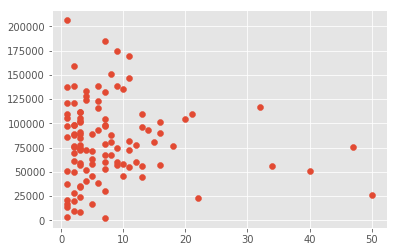

In [61]:
plt.scatter(o_num_ven.values(),o_num_pop.values())

In [62]:
#pop_ven = []
# # pop_ven = pd.DataFrame()
# # pop_ven['District'] = num_pop.keys()
# # pop_ven['Population'] = num_pop.values()
# # pop_ven['Venues'] = num_ven.values()
# # pop_ven
pop_ven = pd.DataFrame([num_pop, num_ven]).T
pop_ven.columns = ['Population', 'Venues']
pop_ven

,Population,Venues
Aeroport,74775,9
Akademichesky,96172,13
Alexeyevsky,73429,3
Altufyevsky,50091,2
Arbat,25699,50
Babushkinsky,77491,12
Basmanny,100899,3
Begovoy,44385,13
Beskudnikovsky,74790,3
Bibirevo,151334,8


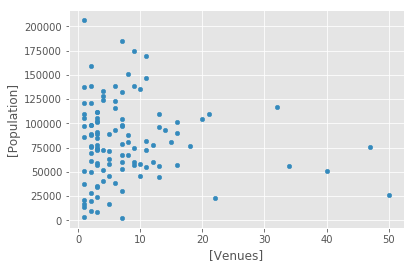

In [63]:
pop_ven.plot.scatter(['Venues'], ['Population'])

/home/jupyterlab/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 52.46288917228487)

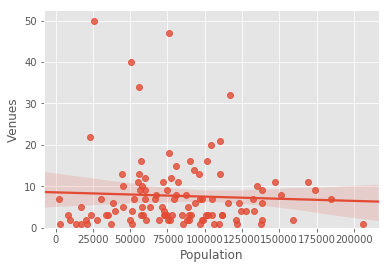

In [64]:
sns.regplot(x=pop_ven['Population'], y=pop_ven['Venues'])
plt.ylim(0,)

In [65]:
import geopy.distance
adr1 = 'Khamovniki, Moscow'
geolocator = Nominatim(user_agent='IBM')
lc1 = geolocator.geocode(adr1)
lt1 = lc1.latitude
lo1 = lc1.longitude
print('Coordinates of {} are {}, {}.'.format(adr1, lt1, lo1))
print()
adr2 = 'Lyublino, Moscow'
geolocator = Nominatim(user_agent='IBM')
lc2 = geolocator.geocode(adr2)
lt2 = lc2.latitude
lo2 = lc2.longitude
print('Coordinates of {} are {}, {}.'.format(adr2, lt2, lo2))


Coordinates of Khamovniki, Moscow are 55.7400467, 37.5739579.

Coordinates of Lyublino, Moscow are 55.6756376, 37.7618058.


In [66]:
print(geopy.distance.distance((lt1, lo1), (lt2, lo2)))

13.815484027178591 km


In [67]:
food_data.head()

,FullPlaceName,District,Borough,Latitude,Longitude,Population,Venue,VenueLatitude,VenueLongitude,CommonCategory,Category
0,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Corner Café & Kitchen,55.751496,37.586757,restaurant,Japanese Restaurant
1,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Граци Рагацци,55.752137,37.591267,restaurant,Italian Restaurant
2,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Бараshка,55.752055,37.586117,restaurant,Middle Eastern Restaurant
3,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Taksim,55.752240,37.591971,restaurant,Turkish Restaurant
4,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Чайхона № 1,55.752383,37.585924,restaurant,Middle Eastern Restaurant


In [68]:
food_data.head()

,FullPlaceName,District,Borough,Latitude,Longitude,Population,Venue,VenueLatitude,VenueLongitude,CommonCategory,Category
0,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Corner Café & Kitchen,55.751496,37.586757,restaurant,Japanese Restaurant
1,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Граци Рагацци,55.752137,37.591267,restaurant,Italian Restaurant
2,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Бараshка,55.752055,37.586117,restaurant,Middle Eastern Restaurant
3,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Taksim,55.752240,37.591971,restaurant,Turkish Restaurant
4,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Чайхона № 1,55.752383,37.585924,restaurant,Middle Eastern Restaurant


In [69]:
def distancometer(x, y):
    v = (x,y)
    msk = (55.751244, 37.618423)
    return geopy.distance.distance(msk, v)
food_data['Distance'] = food_data.apply(lambda x: distancometer(x['Latitude'], x['Longitude']),axis=1)

In [70]:
food_data.head()

,FullPlaceName,District,Borough,Latitude,Longitude,Population,Venue,VenueLatitude,VenueLongitude,CommonCategory,Category,Distance
0,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Corner Café & Kitchen,55.751496,37.586757,restaurant,Japanese Restaurant,1.792840486909856 km
1,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Граци Рагацци,55.752137,37.591267,restaurant,Italian Restaurant,1.792840486909856 km
2,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Бараshка,55.752055,37.586117,restaurant,Middle Eastern Restaurant,1.792840486909856 km
3,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Taksim,55.752240,37.591971,restaurant,Turkish Restaurant,1.792840486909856 km
4,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Чайхона № 1,55.752383,37.585924,restaurant,Middle Eastern Restaurant,1.792840486909856 km


In [71]:
food_data['Distance'] = food_data.Distance.astype(str).str[:-3].astype(float)

In [72]:
food_data.head()

,FullPlaceName,District,Borough,Latitude,Longitude,Population,Venue,VenueLatitude,VenueLongitude,CommonCategory,Category,Distance
0,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Corner Café & Kitchen,55.751496,37.586757,restaurant,Japanese Restaurant,1.79284
1,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Граци Рагацци,55.752137,37.591267,restaurant,Italian Restaurant,1.79284
2,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Бараshка,55.752055,37.586117,restaurant,Middle Eastern Restaurant,1.79284
3,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Taksim,55.752240,37.591971,restaurant,Turkish Restaurant,1.79284
4,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Чайхона № 1,55.752383,37.585924,restaurant,Middle Eastern Restaurant,1.79284


In [73]:
distances = pd.DataFrame(food_data.groupby(['Borough', 'Distance'])['Venue'].count().reset_index())
distances.head()

,Borough,Distance,Venue
0,Aeroport,7.533341,9
1,Akademichesky,7.344038,13
2,Alexeyevsky,6.928859,3
3,Altufyevsky,14.547849,2
4,Arbat,1.792840,50


In [74]:
distances = distances.sort_values(by=['Distance'], ascending=False)
distances

,Borough,Distance,Venue
33,Kiyevsky,59.271786,1
51,Matushkino,39.005143,4
40,Kryukovo,38.122109,7
70,Pervomayskoye,37.729388,3
77,Savyolki,36.273841,3
17,Desyonovskoye,31.498974,1
83,Shcherbinka,27.392074,1
55,Molzhaninovsky,25.401297,1
95,Vnukovo,25.331987,2
104,Yuzhnoye Butovo,23.994534,3


[1, 4, 7, 3, 3, 1, 1, 1, 2, 3, 7, 1, 3, 2, 9, 1, 4, 1, 5, 9, 2, 2, 7, 2, 5, 4, 1, 6, 3, 7, 7, 20, 1, 2, 1, 3, 6, 8, 4, 2, 6, 2, 3, 2, 4, 3, 1, 7, 18, 12, 4, 8, 3, 3, 3, 11, 7, 1, 13, 8, 5, 7, 6, 3, 2, 9, 10, 2, 3, 14, 3, 3, 11, 11, 5, 2, 1, 16, 2, 16, 3, 2, 7, 10, 9, 15, 13, 6, 2, 11, 7, 3, 13, 5, 11, 8, 12, 9, 16, 13, 5, 32, 3, 10, 21, 34, 7, 47, 40, 50, 22]
Venues: [1, 4, 7, 3, 3, 1, 1, 1, 2, 3, 7, 1, 3, 2, 9, 1, 4, 1, 5, 9, 2, 2, 7, 2, 5, 4, 1, 6, 3, 7, 7, 20, 1, 2, 1, 3, 6, 8, 4, 2, 6, 2, 3, 2, 4, 3, 1, 7, 18, 12, 4, 8, 3, 3, 3, 11, 7, 1, 13, 8, 5, 7, 6, 3, 2, 9, 10, 2, 3, 14, 3, 3, 11, 11, 5, 2, 1, 16, 2, 16, 3, 2, 7, 10, 9, 15, 13, 6, 2, 11, 7, 3, 13, 5, 11, 8, 12, 9, 16, 13, 5, 32, 3, 10, 21, 34, 7, 47, 40, 50, 22]

Distances: [59, 39, 38, 37, 36, 31, 27, 25, 25, 23, 21, 21, 20, 20, 18, 18, 18, 17, 17, 17, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 11, 11, 11, 11, 11, 11, 10,

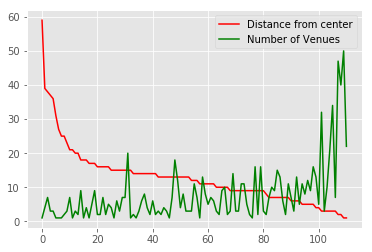

In [75]:
n = distances.Distance.to_list()
x = distances.Venue.to_list()
y = []
for i in n:
    y.append(int(i))
print(x)
print('Venues:', x)
print()
print('Distances:', y)
plt.plot(y, color='red')
plt.plot(x, color='green')
plt.legend(['Distance from center','Number of Venues'])
plt.show()

In [76]:
from scipy import stats
from scipy.stats import linregress
linregress(x,y)

LinregressResult(slope=-0.42066843281622585, intercept=16.067683305617166, rvalue=-0.42517423714917085, pvalue=3.295796301783116e-06, stderr=0.08577521732636838)

(0, 54.06648561809675)

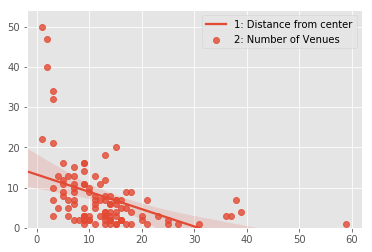

In [77]:
sns.regplot(y, x)
plt.legend(['1: Distance from center','2: Number of Venues'])
plt.ylim(0,)

(0, 62.71675319542572)

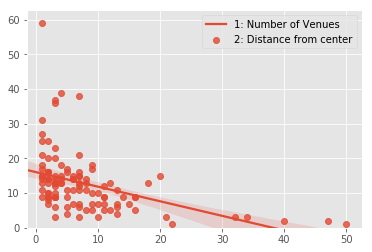

In [78]:
sns.regplot(x, y)
plt.legend(['1: Number of Venues', '2: Distance from center',])
plt.ylim(0,)

In [79]:
distances.head()

,Borough,Distance,Venue
33,Kiyevsky,59.271786,1
51,Matushkino,39.005143,4
40,Kryukovo,38.122109,7
70,Pervomayskoye,37.729388,3
77,Savyolki,36.273841,3


In [80]:
stats.pearsonr(y,x)

(-0.42517423714917096, 3.2957963017830717e-06)

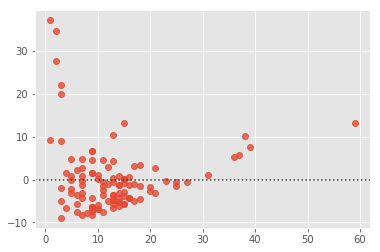

In [81]:
sns.residplot(y,x)

<H1>Clustering</H1>

In [82]:
moscow_data.head(2)

,District,Borough,FullPlaceName,Latitude,Longitude,Population
0,Central Administrative Okrug,Arbat,"Central Administrative Okrug, Arbat",55.751199,37.589872,25699
1,Central Administrative Okrug,Basmanny,"Central Administrative Okrug, Basmanny",55.767281,37.669773,100899


In [83]:
food_data.head(2)

,FullPlaceName,District,Borough,Latitude,Longitude,Population,Venue,VenueLatitude,VenueLongitude,CommonCategory,Category,Distance
0,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Corner Café & Kitchen,55.751496,37.586757,restaurant,Japanese Restaurant,1.79284
1,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Граци Рагацци,55.752137,37.591267,restaurant,Italian Restaurant,1.79284


In [84]:
distances.head(2)

,Borough,Distance,Venue
33,Kiyevsky,59.271786,1
51,Matushkino,39.005143,4


In [85]:
complete_data = pd.merge(food_data, distances, on='Borough')
complete_data = complete_data.drop(columns='Distance_y')
complete_data.head(1)

,FullPlaceName,District,Borough,Latitude,Longitude,Population,Venue_x,VenueLatitude,VenueLongitude,CommonCategory,Category,Distance_x,Venue_y
0,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Corner Café & Kitchen,55.751496,37.586757,restaurant,Japanese Restaurant,1.79284,50


In [86]:
complete_data.head()

,FullPlaceName,District,Borough,Latitude,Longitude,Population,Venue_x,VenueLatitude,VenueLongitude,CommonCategory,Category,Distance_x,Venue_y
0,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Corner Café & Kitchen,55.751496,37.586757,restaurant,Japanese Restaurant,1.79284,50
1,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Граци Рагацци,55.752137,37.591267,restaurant,Italian Restaurant,1.79284,50
2,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Бараshка,55.752055,37.586117,restaurant,Middle Eastern Restaurant,1.79284,50
3,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Taksim,55.752240,37.591971,restaurant,Turkish Restaurant,1.79284,50
4,"Central Administrative Okrug, Arbat",Central Administrative Okrug,Arbat,55.751199,37.589872,25699,Чайхона № 1,55.752383,37.585924,restaurant,Middle Eastern Restaurant,1.79284,50


In [87]:
complete_data.shape

(857, 13)

In [150]:
# leave only the necessary data for clustering
ven_data = food_data[['District', 'Borough', 'Latitude', 'Longitude', 'Venue', 'VenueLatitude', 'VenueLongitude', 'Category']]

<h3>KMeans Analysis</h3>

In [151]:
# one hot encoding
m_onehot = pd.get_dummies(ven_data[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
m_onehot['Borough'] = ven_data['Borough']

# move neighborhood column to the first column
fixed_columns = [m_onehot.columns[-1]] + list(m_onehot.columns[:-1])
m_onehot = m_onehot[fixed_columns]

m_onehot.head()

,Borough,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Belgian Restaurant,Bistro,...,Steakhouse,Sushi Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint
0,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [152]:
m_onehot.shape

(857, 73)

In [153]:
# Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
m_grouped = m_onehot.groupby('Borough').mean().reset_index()
m_grouped.head()

,Borough,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Belgian Restaurant,Bistro,...,Steakhouse,Sushi Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint
0,Aeroport,0.00,0.0,0.00,0.00,0.333333,0.00,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,0.111111,0.00
1,Akademichesky,0.00,0.0,0.00,0.00,0.153846,0.00,0.0,0.0,0.0,...,0.0,0.153846,0.0,0.0,0.00,0.0,0.0,0.076923,0.000000,0.00
2,Alexeyevsky,0.00,0.0,0.00,0.00,0.000000,0.00,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.00
3,Altufyevsky,0.00,0.0,0.00,0.00,0.000000,0.00,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.00
4,Arbat,0.02,0.0,0.02,0.02,0.100000,0.02,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.04,0.0,0.0,0.020000,0.020000,0.02


In [154]:
# confirm the new size
m_grouped.shape

(111, 73)

In [156]:
# print each neighborhood along with the top 5 most common venues

for hood in m_grouped['Borough']:
#    print("----"+hood+"----")
    temp = m_grouped[m_grouped['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
#    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
#    print('\n')


# put that into a pandas dataframe
# function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]

#Now let's create the new dataframe and display the top 10 venues for each neighborhood.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Borough'] = m_grouped['Borough']

for ind in np.arange(m_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(m_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)



,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aeroport,Coffee Shop,Bakery,Wine Shop,Burger Joint,Donut Shop,Creperie,Cupcake Shop,Czech Restaurant,Dessert Shop,Diner
1,Akademichesky,Sushi Restaurant,Bakery,Pizza Place,Cocktail Bar,Pub,Restaurant,Sandwich Place,Italian Restaurant,Fast Food Restaurant,Wine Bar
2,Alexeyevsky,Pizza Place,Diner,German Restaurant,Cocktail Bar,Coffee Shop,Creperie,Cupcake Shop,Czech Restaurant,Dessert Shop,Wings Joint
3,Altufyevsky,Pizza Place,Café,Wings Joint,Coffee Shop,Creperie,Cupcake Shop,Czech Restaurant,Dessert Shop,Diner,Donut Shop
4,Arbat,Coffee Shop,Bakery,Burger Joint,Italian Restaurant,Turkish Restaurant,Café,Caucasian Restaurant,Middle Eastern Restaurant,Wings Joint,Food Court


In [157]:
#Run k-means to cluster the neighborhood into 5 clusters.

# set number of clusters
kclusters = 5

m_grouped_clustering = m_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(m_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

#Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [199]:
neighborhoods_venues_sorted.head(1)

,Cluster Labels,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,Aeroport,Coffee Shop,Bakery,Wine Shop,Burger Joint,Donut Shop,Creperie,Cupcake Shop,Czech Restaurant,Dessert Shop,Diner


In [200]:
ven_data.head(1)

,District,Borough,Latitude,Longitude,Venue,VenueLatitude,VenueLongitude,Category
0,Central Administrative Okrug,Arbat,55.751199,37.589872,Corner Café & Kitchen,55.751496,37.586757,Japanese Restaurant


In [211]:
m_merged = ven_data[['District', 'Borough', 'Latitude', 'Longitude']]
m_merged = m_merged.join(neighborhoods_venues_sorted.set_index('Borough'), on='Borough')
m_merged = m_merged.drop_duplicates(keep = 'first')
m_merged

# m_merged = ven_data

# # merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
# m_merged = m_merged.join(neighborhoods_venues_sorted.set_index('Borough'), on='Borough')

# m_merged.head() # check the last columns!

,District,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Administrative Okrug,Arbat,55.751199,37.589872,3,Coffee Shop,Bakery,Burger Joint,Italian Restaurant,Turkish Restaurant,Café,Caucasian Restaurant,Middle Eastern Restaurant,Wings Joint,Food Court
50,Central Administrative Okrug,Basmanny,55.767281,37.669773,3,Coffee Shop,Irish Pub,Mexican Restaurant,Donut Shop,Creperie,Cupcake Shop,Czech Restaurant,Dessert Shop,Diner,Wings Joint
53,Central Administrative Okrug,Khamovniki,55.740047,37.573958,3,Pizza Place,Pastry Shop,Caucasian Restaurant,Bakery,Modern European Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Dessert Shop,Creperie,Cupcake Shop
60,Central Administrative Okrug,Krasnoselsky,55.777447,37.654160,3,Hotel Bar,Bakery,Coffee Shop,Asian Restaurant,Middle Eastern Restaurant,Café,Cafeteria,Burger Joint,Donut Shop,Czech Restaurant
70,Central Administrative Okrug,Meshchansky,55.779169,37.627755,3,Coffee Shop,Bakery,Middle Eastern Restaurant,Restaurant,Caucasian Restaurant,Café,Gourmet Shop,Dumpling Restaurant,Donut Shop,Cupcake Shop
104,Central Administrative Okrug,Presnensky,55.762215,37.560658,3,Coffee Shop,Café,Wine Bar,Caucasian Restaurant,Bar,French Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Cafeteria,Cupcake Shop
136,Central Administrative Okrug,Tagansky,55.741572,37.667063,3,Bar,Coffee Shop,Café,Caucasian Restaurant,Eastern European Restaurant,Dessert Shop,Gastropub,Restaurant,Burger Joint,Snack Place
157,Central Administrative Okrug,Tverskoy,55.769146,37.608835,3,Coffee Shop,Cocktail Bar,Italian Restaurant,Wine Bar,Seafood Restaurant,Restaurant,Steakhouse,Beer Bar,Pub,Café
204,Central Administrative Okrug,Yakimanka,55.738374,37.616913,3,Coffee Shop,Café,Restaurant,Caucasian Restaurant,Lounge,Asian Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Bakery,Eastern European Restaurant
226,Central Administrative Okrug,Zamoskvorechye,55.735664,37.634867,3,Coffee Shop,Caucasian Restaurant,Café,Bakery,Steakhouse,Modern European Restaurant,Italian Restaurant,Sushi Restaurant,Restaurant,Gourmet Shop


In [317]:
# create map
mcl_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
# rainbow = ['#ff0000','#00a336','#8000ff','#974e4c','#06b6eb']
rainbow = ['#e24a33', '#348abd','#988ed5','#777777','#fbc15e']
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(m_merged['Latitude'], m_merged['Longitude'], m_merged['Borough'],
                                  m_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    try:
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster)],
            fill=True,
            fill_color=rainbow[int(cluster)],
            fill_opacity=1).add_to(mcl_map)
    except:
        continue



In [318]:
# show the cluster map
mcl_map

In [305]:
#Cluster 1
m_merged.loc[m_merged['Cluster Labels'] == 0, m_merged.columns[[1] + list(range(5, m_merged.shape[1]))]]

Borough                   16
1st Most Common Venue     16
2nd Most Common Venue     16
3rd Most Common Venue     16
4th Most Common Venue     16
5th Most Common Venue     16
6th Most Common Venue     16
7th Most Common Venue     16
8th Most Common Venue     16
9th Most Common Venue     16
10th Most Common Venue    16
dtype: int64

In [306]:
#Cluster 2
m_merged.loc[m_merged['Cluster Labels'] == 1, m_merged.columns[[1] + list(range(5, m_merged.shape[1]))]]

Borough                   20
1st Most Common Venue     20
2nd Most Common Venue     20
3rd Most Common Venue     20
4th Most Common Venue     20
5th Most Common Venue     20
6th Most Common Venue     20
7th Most Common Venue     20
8th Most Common Venue     20
9th Most Common Venue     20
10th Most Common Venue    20
dtype: int64

In [307]:
#Cluster 3
m_merged.loc[m_merged['Cluster Labels'] == 2, m_merged.columns[[1] + list(range(5, m_merged.shape[1]))]]


Borough                   12
1st Most Common Venue     12
2nd Most Common Venue     12
3rd Most Common Venue     12
4th Most Common Venue     12
5th Most Common Venue     12
6th Most Common Venue     12
7th Most Common Venue     12
8th Most Common Venue     12
9th Most Common Venue     12
10th Most Common Venue    12
dtype: int64

In [308]:
#Cluster 4
m_merged.loc[m_merged['Cluster Labels'] == 3, m_merged.columns[[1] + list(range(5, m_merged.shape[1]))]]


Borough                   60
1st Most Common Venue     60
2nd Most Common Venue     60
3rd Most Common Venue     60
4th Most Common Venue     60
5th Most Common Venue     60
6th Most Common Venue     60
7th Most Common Venue     60
8th Most Common Venue     60
9th Most Common Venue     60
10th Most Common Venue    60
dtype: int64

In [309]:
#Cluster 5
m_merged.loc[m_merged['Cluster Labels'] == 4, m_merged.columns[[1] + list(range(5, m_merged.shape[1]))]]

Borough                   3
1st Most Common Venue     3
2nd Most Common Venue     3
3rd Most Common Venue     3
4th Most Common Venue     3
5th Most Common Venue     3
6th Most Common Venue     3
7th Most Common Venue     3
8th Most Common Venue     3
9th Most Common Venue     3
10th Most Common Venue    3
dtype: int64

In [276]:
# variables
cl_cats = [
    '1st Most Common Venue', 
    '2nd Most Common Venue',
    '3rd Most Common Venue',
    '4th Most Common Venue',
    '5th Most Common Venue',
    '6th Most Common Venue',
    '7th Most Common Venue',
    '8th Most Common Venue',
    '9th Most Common Venue',
    '10th Most Common Venue']

# function to work on clusters

def cl_pop_ven(cl_cats, cl_num, top_num):
    cl = m_merged.loc[m_merged['Cluster Labels'] == cl_num, m_merged.columns[[1] + list(range(5, m_merged.shape[1]))]]
    cl_cat = cl[cl_cats]
    cl_cat_count = pd.DataFrame(pd.DataFrame(cl_cat.apply(pd.Series.value_counts)).sum(axis=1, skipna=True))
    return cl_cat_count[0].nlargest(top_num)
                                


In [277]:
neighborhoods_venues_sorted.head()

,Cluster Labels,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,Aeroport,Coffee Shop,Bakery,Wine Shop,Burger Joint,Donut Shop,Creperie,Cupcake Shop,Czech Restaurant,Dessert Shop,Diner
1,3,Akademichesky,Sushi Restaurant,Bakery,Pizza Place,Cocktail Bar,Pub,Restaurant,Sandwich Place,Italian Restaurant,Fast Food Restaurant,Wine Bar
2,2,Alexeyevsky,Pizza Place,Diner,German Restaurant,Cocktail Bar,Coffee Shop,Creperie,Cupcake Shop,Czech Restaurant,Dessert Shop,Wings Joint
3,0,Altufyevsky,Pizza Place,Café,Wings Joint,Coffee Shop,Creperie,Cupcake Shop,Czech Restaurant,Dessert Shop,Diner,Donut Shop
4,3,Arbat,Coffee Shop,Bakery,Burger Joint,Italian Restaurant,Turkish Restaurant,Café,Caucasian Restaurant,Middle Eastern Restaurant,Wings Joint,Food Court


In [278]:
m_merged.head()

,District,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Administrative Okrug,Arbat,55.751199,37.589872,3,Coffee Shop,Bakery,Burger Joint,Italian Restaurant,Turkish Restaurant,Café,Caucasian Restaurant,Middle Eastern Restaurant,Wings Joint,Food Court
50,Central Administrative Okrug,Basmanny,55.767281,37.669773,3,Coffee Shop,Irish Pub,Mexican Restaurant,Donut Shop,Creperie,Cupcake Shop,Czech Restaurant,Dessert Shop,Diner,Wings Joint
53,Central Administrative Okrug,Khamovniki,55.740047,37.573958,3,Pizza Place,Pastry Shop,Caucasian Restaurant,Bakery,Modern European Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Dessert Shop,Creperie,Cupcake Shop
60,Central Administrative Okrug,Krasnoselsky,55.777447,37.654160,3,Hotel Bar,Bakery,Coffee Shop,Asian Restaurant,Middle Eastern Restaurant,Café,Cafeteria,Burger Joint,Donut Shop,Czech Restaurant
70,Central Administrative Okrug,Meshchansky,55.779169,37.627755,3,Coffee Shop,Bakery,Middle Eastern Restaurant,Restaurant,Caucasian Restaurant,Café,Gourmet Shop,Dumpling Restaurant,Donut Shop,Cupcake Shop


In [281]:
# See top venues in each cluster

for i in range(6):
    print('Cluster', i+1, ':')
    print(cl_pop_ven(cl_cats, i, 10))
    print()

Cluster 1 :
Café                16.0
Dessert Shop        13.0
Creperie            12.0
Diner               12.0
Cupcake Shop        11.0
Czech Restaurant    11.0
Donut Shop          10.0
Wings Joint          9.0
Coffee Shop          6.0
Restaurant           5.0
Name: 0, dtype: float64

Cluster 2 :
Creperie                17.0
Cupcake Shop            16.0
Sushi Restaurant        16.0
Dessert Shop            15.0
Coffee Shop             14.0
Czech Restaurant        14.0
Diner                   13.0
Fast Food Restaurant    13.0
Wings Joint             12.0
Donut Shop              11.0
Name: 0, dtype: float64

Cluster 3 :
Coffee Shop          12.0
Creperie             12.0
Cupcake Shop         12.0
Czech Restaurant     12.0
Pizza Place          12.0
Dessert Shop         11.0
Diner                11.0
Wings Joint          10.0
Cocktail Bar          8.0
German Restaurant     5.0
Name: 0, dtype: float64

Cluster 4 :
Coffee Shop             44.0
Dessert Shop            34.0
Cupcake Shop       

Cluster 1


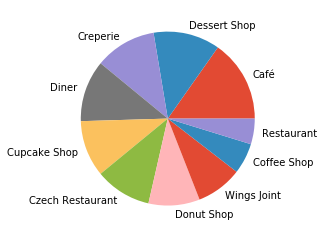

In [319]:
cl_pop_ven(cl_cats, 0, 10).plot(kind='pie', label='')
print('Cluster 1')

Cluster 2


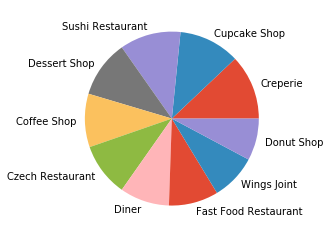

In [320]:
cl_pop_ven(cl_cats, 1, 10).plot(kind='pie', label='')
print('Cluster 2')

Cluster 3


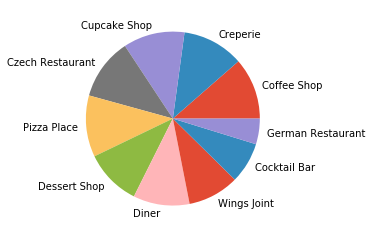

In [321]:
cl_pop_ven(cl_cats, 2, 10).plot(kind='pie', label='')
print('Cluster 3')

Cluster 4


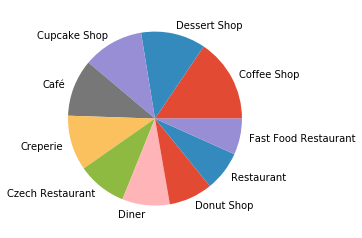

In [322]:
cl_pop_ven(cl_cats, 3, 10).plot(kind='pie', label='')
print('Cluster 4')

Cluster 5


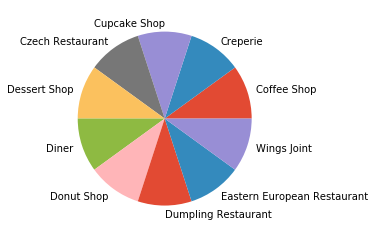

In [323]:
cl_pop_ven(cl_cats, 4, 10).plot(kind='pie', label='')
print('Cluster 5')

In [324]:
df01 = pd.DataFrame(cl_pop_ven(cl_cats, 0, 10)).reset_index()
df02 = pd.DataFrame(cl_pop_ven(cl_cats, 1, 10)).reset_index()
df03 = pd.DataFrame(cl_pop_ven(cl_cats, 2, 10)).reset_index()
df04 = pd.DataFrame(cl_pop_ven(cl_cats, 3, 10)).reset_index()
df05 = pd.DataFrame(cl_pop_ven(cl_cats, 4, 10)).reset_index()
# df_all = [df01, df02, df03, df04, df05]


In [325]:
df01.head()

,index,0
0,Café,16.0
1,Dessert Shop,13.0
2,Creperie,12.0
3,Diner,12.0
4,Cupcake Shop,11.0


In [326]:
df02.head()

,index,0
0,Creperie,17.0
1,Cupcake Shop,16.0
2,Sushi Restaurant,16.0
3,Dessert Shop,15.0
4,Coffee Shop,14.0


In [327]:
df03.head()

,index,0
0,Coffee Shop,12.0
1,Creperie,12.0
2,Cupcake Shop,12.0
3,Czech Restaurant,12.0
4,Pizza Place,12.0


In [328]:
df04.head()


,index,0
0,Coffee Shop,44.0
1,Dessert Shop,34.0
2,Cupcake Shop,32.0
3,Café,30.0
4,Creperie,29.0


In [329]:
df05.head()

,index,0
0,Coffee Shop,3.0
1,Creperie,3.0
2,Cupcake Shop,3.0
3,Czech Restaurant,3.0
4,Dessert Shop,3.0


In [330]:
df01.shape


(10, 2)

In [331]:
df_all = df01

In [332]:
df_all = pd.merge(df_all, df02, on='index', how='outer')
df_all = pd.merge(df_all, df03, on = 'index', how = 'outer')
df_all = pd.merge(df_all, df04, on = 'index', how = 'outer')
df_all = pd.merge(df_all, df05, on = 'index', how = 'outer')
df_all.head()

,index,0_x,0_y,0_x,0_y,0
0,Café,16.0,NaN,NaN,30.0,NaN
1,Dessert Shop,13.0,15.0,11.0,34.0,3.0
2,Creperie,12.0,17.0,12.0,29.0,3.0
3,Diner,12.0,13.0,11.0,25.0,3.0
4,Cupcake Shop,11.0,16.0,12.0,32.0,3.0


In [333]:
df_all.columns = ['Category', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']

In [334]:
df_all.head()

,Category,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
0,Café,16.0,NaN,NaN,30.0,NaN
1,Dessert Shop,13.0,15.0,11.0,34.0,3.0
2,Creperie,12.0,17.0,12.0,29.0,3.0
3,Diner,12.0,13.0,11.0,25.0,3.0
4,Cupcake Shop,11.0,16.0,12.0,32.0,3.0


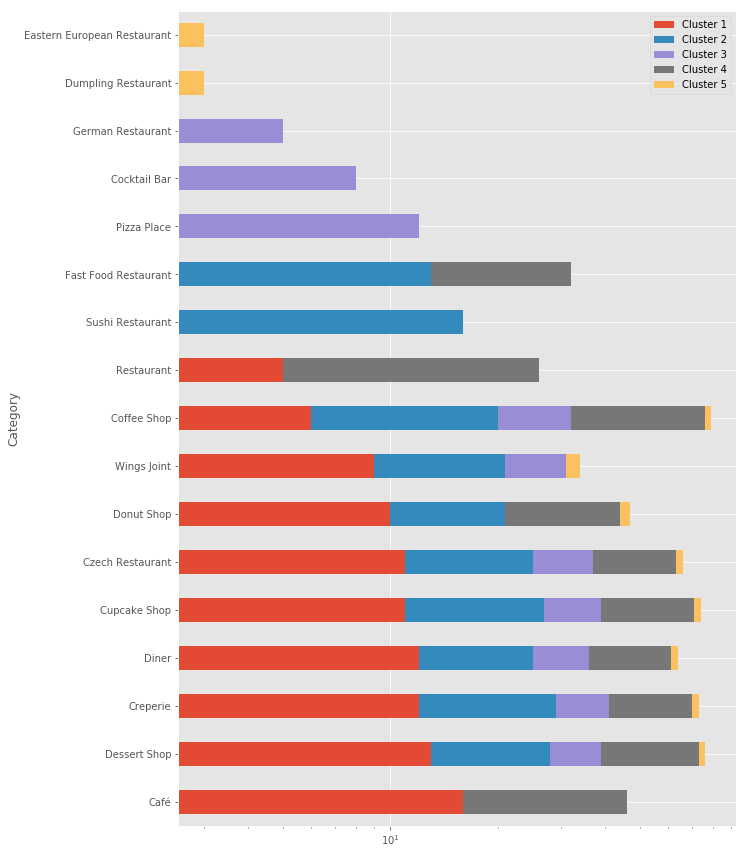

In [335]:
df_all.set_index('Category').plot(kind='barh', figsize=(10,15), logx = True, stacked = True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd69a612940>,
      dtype=object)

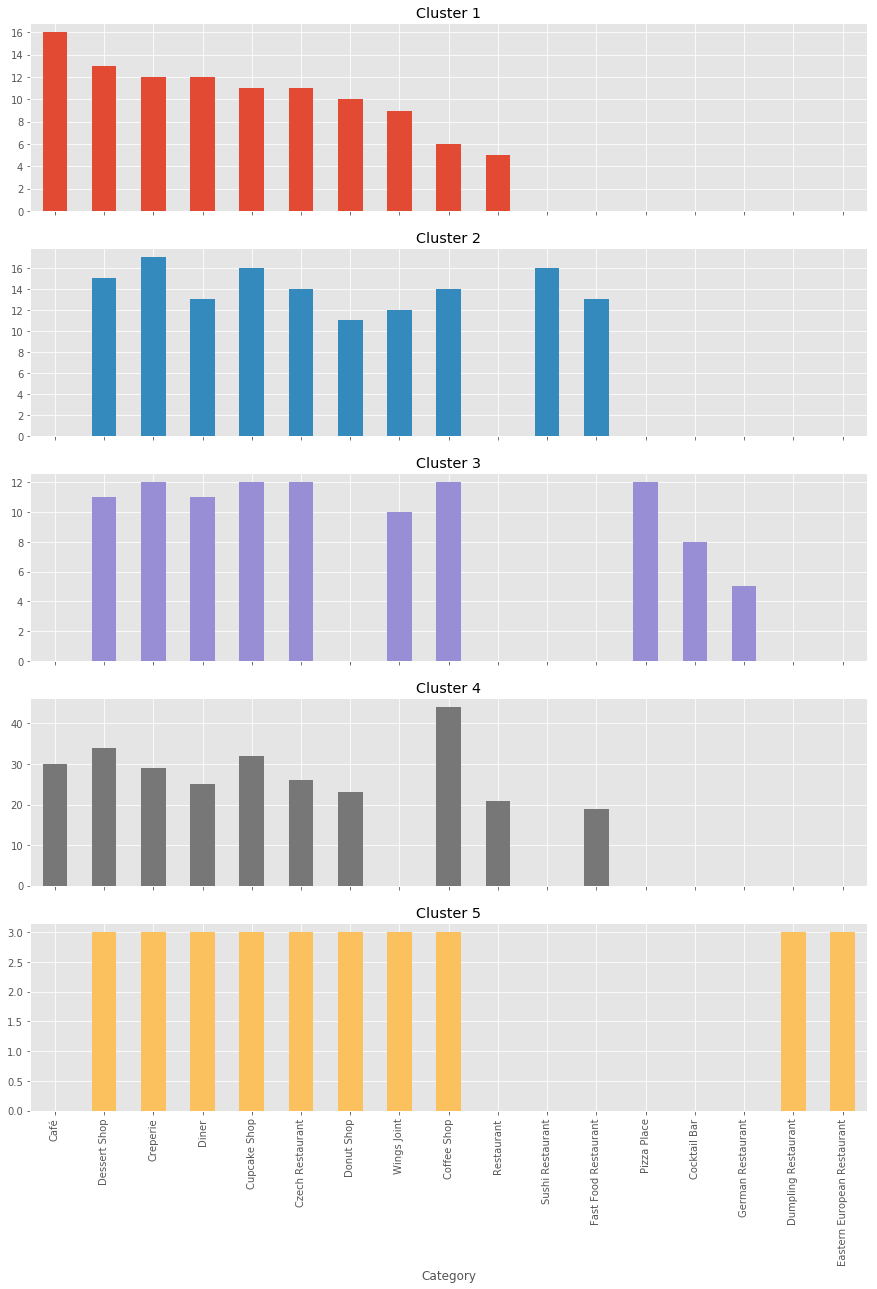

In [336]:
df_all.set_index('Category').plot(kind='bar', figsize=(15,20), logx = False, subplots = True, legend=False)

In [337]:
df_all

,Category,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
0,Café,16.0,NaN,NaN,30.0,NaN
1,Dessert Shop,13.0,15.0,11.0,34.0,3.0
2,Creperie,12.0,17.0,12.0,29.0,3.0
3,Diner,12.0,13.0,11.0,25.0,3.0
4,Cupcake Shop,11.0,16.0,12.0,32.0,3.0
5,Czech Restaurant,11.0,14.0,12.0,26.0,3.0
6,Donut Shop,10.0,11.0,NaN,23.0,3.0
7,Wings Joint,9.0,12.0,10.0,NaN,3.0
8,Coffee Shop,6.0,14.0,12.0,44.0,3.0
9,Restaurant,5.0,NaN,NaN,21.0,NaN


In [340]:
df_all['Total'] = df_all.sum(axis=1, skipna=True)

In [341]:
df_all

,Category,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Total
0,Café,16.0,NaN,NaN,30.0,NaN,46.0
1,Dessert Shop,13.0,15.0,11.0,34.0,3.0,76.0
2,Creperie,12.0,17.0,12.0,29.0,3.0,73.0
3,Diner,12.0,13.0,11.0,25.0,3.0,64.0
4,Cupcake Shop,11.0,16.0,12.0,32.0,3.0,74.0
5,Czech Restaurant,11.0,14.0,12.0,26.0,3.0,66.0
6,Donut Shop,10.0,11.0,NaN,23.0,3.0,47.0
7,Wings Joint,9.0,12.0,10.0,NaN,3.0,34.0
8,Coffee Shop,6.0,14.0,12.0,44.0,3.0,79.0
9,Restaurant,5.0,NaN,NaN,21.0,NaN,26.0
